In [ ]:
# Osmotic avoidance ring assay (WormLab) — analysis notebook

This notebook:
- loads WormLab exports (Position, Speed, Area, Length) for 4 videos in a group
- reshapes wide-format tracks to long format
- corrects per-video label coordinates (px top-left → µm bottom-left)
- produces QC plots and behavioral metrics (crossing, encounters, speeds, volume)


In [1]:
# === Parameters (edit these) ===
W_PX = 2456
H_PX = 2052
UM_PER_PX = 17.54

# Labels order (inner → outer): 1, 0, 2
INNER_LABEL_ID = 1
OUTER_LABEL_ID = 0
PLATE_LABEL_ID = 2

# Crossing definition: first inside→outside of INNER_LABEL_ID
CROSSING_LABEL_ID = INNER_LABEL_ID

# Zoning / encounters (inside INNER label)
N_ZONES = 100
ENCOUNTER_ZONE_MIN = 75
ENCOUNTER_ZONE_MAX = 100
ENCOUNTER_DWELL_S = 1.0

# Speed/volume binning
ZONE_BIN_SIZE = 10  # set to 1 for per-zone


In [2]:
import os
import re
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [39]:
# === Configuration (start with ONE video: video 2) ===
genotype = "osm-8(dr170)"
condition = "food"

bundle_vid2 = {
    "video_id": "vid2",
    "position_csv": r"/Users/todd/VSCode_projects/osm8 ring assays/data/raw/dr170 Food/video 2/dr170 Food D1 20c 20001 Position.csv",
    "speed_csv":    r"/Users/todd/VSCode_projects/osm8 ring assays/data/raw/dr170 Food/video 2/dr170 Food D1 20c 20001 Speed.csv",
    "area_csv":     r"/Users/todd/VSCode_projects/osm8 ring assays/data/raw/dr170 Food/video 2/dr170 Food D1 20c 20001 Area.csv",
    "length_csv":   r"/Users/todd/VSCode_projects/osm8 ring assays/data/raw/dr170 Food/video 2/dr170 Food D1 20c 20001 Length.csv",
    "labels_csv":   r"/Users/todd/VSCode_projects/osm8 ring assays/data/raw/dr170 Food/video 2/dr170 Food D1 20c 20001 Labels.csv",
    "fit_csv":      r"/Users/todd/VSCode_projects/osm8 ring assays/data/raw/dr170 Food/video 2/dr170 Food D1 20c 20001 Fit.csv",   # optional
}

video_bundles = [bundle_vid2]


In [8]:
import glob, os

folder = os.path.dirname(video_bundles[0]["position_csv"])
files = glob.glob(os.path.join(folder, "*.csv"))

print("Folder:", folder)
print("CSV files found:")
for f in files:
    print("  ", os.path.basename(f))

def pick(keyword):
    hits = [f for f in files if keyword.lower() in os.path.basename(f).lower()]
    return hits[0] if hits else None

video_bundles[0]["speed_csv"]  = pick("speed")
video_bundles[0]["area_csv"]   = pick("area")
video_bundles[0]["length_csv"] = pick("length")
video_bundles[0]["labels_csv"] = pick("labels")
video_bundles[0]["fit_csv"]    = pick("fit")  # may be None

video_bundles[0]


Folder: /Users/todd/VSCode_projects/osm8 ring assays/data/raw/dr170 Food/video 2
CSV files found:
   dr170 Food D1 20c 20001 Direction.csv
   dr170 Food D1 20c 20001 Position.csv
   dr170 Food D1 20c 20001 Speed.csv
   dr170 Food D1 20c 20001 Area.csv
   dr170 Food D1 20c 20001 Labels.csv
   dr170 Food D1 20c 20001 Length.csv
   dr170 Food D1 20c 20001 Fit.csv


{'video_id': 'vid2',
 'position_csv': '/Users/todd/VSCode_projects/osm8 ring assays/data/raw/dr170 Food/video 2/dr170 Food D1 20c 20001 Position.csv',
 'speed_csv': '/Users/todd/VSCode_projects/osm8 ring assays/data/raw/dr170 Food/video 2/dr170 Food D1 20c 20001 Speed.csv',
 'area_csv': '/Users/todd/VSCode_projects/osm8 ring assays/data/raw/dr170 Food/video 2/dr170 Food D1 20c 20001 Area.csv',
 'length_csv': '/Users/todd/VSCode_projects/osm8 ring assays/data/raw/dr170 Food/video 2/dr170 Food D1 20c 20001 Length.csv',
 'labels_csv': '/Users/todd/VSCode_projects/osm8 ring assays/data/raw/dr170 Food/video 2/dr170 Food D1 20c 20001 Labels.csv',
 'fit_csv': '/Users/todd/VSCode_projects/osm8 ring assays/data/raw/dr170 Food/video 2/dr170 Food D1 20c 20001 Fit.csv'}

In [10]:
import pandas as pd

pos = pd.read_csv(pos_path, header=1)  # use row 2 as header (0-indexed)
print("Shape:", pos.shape)
print("Columns:", list(pos.columns)[:30])
pos.head()


Shape: (13452, 22)
Columns: ['Frame', 'Time', '1 x', '1 y', '2 x', '2 y', '3 x', '3 y', '4 x', '4 y', '5 x', '5 y', '6 x', '6 y', '7 x', '7 y', '8 x', '8 y', '9 x', '9 y', '10 x', '10 y']


,Frame,Time,1 x,1 y,2 x,2 y,3 x,3 y,4 x,4 y,...,6 x,6 y,7 x,7 y,8 x,8 y,9 x,9 y,10 x,10 y
0,87,11.466667,23232.744726,17708.032057,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,88,11.600000,23224.741859,17713.189653,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,89,11.733333,23213.907755,17718.407161,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,90,11.866667,23196.806473,17725.424240,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,91,12.000000,23179.723115,17733.442820,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
def load_position_wide_to_long(position_csv: str, video_id: str) -> pd.DataFrame:
    df = pd.read_csv(position_csv, header=1)

    # Drop unnamed index-like columns
    df = df.loc[:, ~df.columns.astype(str).str.startswith("Unnamed")]

    cols = list(df.columns)

    # Identify frame and time columns
    frame_candidates = [c for c in cols if str(c).strip().lower() in ["frame", "frames"]]
    time_candidates  = [c for c in cols if "time" in str(c).strip().lower()]

    frame_col = frame_candidates[0] if frame_candidates else cols[0]
    time_col  = time_candidates[0]  if time_candidates  else cols[1]

    # Remaining columns should be X/Y pairs
    remaining = [c for c in cols if c not in [frame_col, time_col]]

    if len(remaining) % 2 != 0:
        raise ValueError(
            f"Expected even number of coordinate columns, got {len(remaining)}. "
            f"First few: {remaining[:10]}"
        )

    x_cols = remaining[0::2]
    y_cols = remaining[1::2]

    long_parts = []
    for i, (xc, yc) in enumerate(zip(x_cols, y_cols), start=1):
        tmp = df[[frame_col, time_col, xc, yc]].copy()
        tmp.columns = ["frame", "time_s", "x_um", "y_um"]
        tmp["video_id"] = video_id
        tmp["track_id"] = f"track_{i}"
        long_parts.append(tmp)

    out = pd.concat(long_parts, ignore_index=True)

    # Drop rows where this track has no position
    out = out.dropna(subset=["x_um", "y_um"])

    # Enforce numeric types
    out["frame"] = pd.to_numeric(out["frame"], errors="coerce")
    out["time_s"] = pd.to_numeric(out["time_s"], errors="coerce")
    out["x_um"] = pd.to_numeric(out["x_um"], errors="coerce")
    out["y_um"] = pd.to_numeric(out["y_um"], errors="coerce")

    out = out.dropna(subset=["frame", "time_s", "x_um", "y_um"])
    out = out.sort_values(["track_id", "time_s"]).reset_index(drop=True)

    counts = out.groupby("track_id").size()
    print(f"[Position] {video_id}: tracks={counts.shape[0]}, "
          f"rows/track min={counts.min()}, med={counts.median()}, max={counts.max()}")

    return out


In [28]:
speed_long = load_metric_wide_to_long(
    bundle_vid2["speed_csv"],
    bundle_vid2["video_id"],
    value_name="speed_um_s"
)

speed_long.head()


[speed_um_s] vid2: tracks=10, rows/track min=811, med=10729.5, max=13306


,frame,time_s,speed_um_s,video_id,track_id
0,87,11.466667,0.000000,vid2,track_1
1,88,11.600000,71.406406,vid2,track_1
2,89,11.733333,90.187371,vid2,track_1
3,90,11.866667,138.637096,vid2,track_1
4,91,12.000000,141.537293,vid2,track_1


In [29]:
# Merge by frame + track_id (most robust when time is sampled identically)
pos_with_speed = pos_long.merge(
    speed_long[["video_id", "track_id", "frame", "speed_um_s"]],
    on=["video_id", "track_id", "frame"],
    how="left"
)

print("Merged shape:", pos_with_speed.shape)
print("Speed missing fraction:", pos_with_speed["speed_um_s"].isna().mean())

pos_with_speed.head()


Merged shape: (101201, 7)
Speed missing fraction: 0.0


,frame,time_s,x_um,y_um,video_id,track_id,speed_um_s
0,87,11.466667,23232.744726,17708.032057,vid2,track_1,0.000000
1,88,11.600000,23224.741859,17713.189653,vid2,track_1,71.406406
2,89,11.733333,23213.907755,17718.407161,vid2,track_1,90.187371
3,90,11.866667,23196.806473,17725.424240,vid2,track_1,138.637096
4,91,12.000000,23179.723115,17733.442820,vid2,track_1,141.537293


In [ ]:
def load_metric_wide_to_long(path: str, video_id: str, value_name: str) -> pd.DataFrame:
    """
    Load a WormLab metric CSV (Speed, Area, Length, etc.) and reshape to long format.
    
    Args:
        path: Path to the metric CSV file
        video_id: Video identifier
        value_name: Name for the metric column (e.g., 'speed_um_s', 'area_um2', 'length_um')
    
    Returns:
        DataFrame with columns: video_id, track_id, frame, time_s, {value_name}
    """
    df = pd.read_csv(path, header=1)
    
    # Drop unnamed index-like columns
    df = df.loc[:, ~df.columns.astype(str).str.startswith("Unnamed")]
    
    cols = list(df.columns)
    
    # Identify frame and time columns
    frame_candidates = [c for c in cols if str(c).strip().lower() in ["frame", "frames"]]
    time_candidates  = [c for c in cols if "time" in str(c).strip().lower()]
    
    frame_col = frame_candidates[0] if frame_candidates else cols[0]
    time_col  = time_candidates[0]  if time_candidates  else cols[1]
    
    # Remaining columns are one per track (same order as Position)
    metric_cols = [c for c in cols if c not in [frame_col, time_col]]
    
    long_parts = []
    for i, mc in enumerate(metric_cols, start=1):
        tmp = df[[frame_col, time_col, mc]].copy()
        tmp.columns = ["frame", "time_s", value_name]
        tmp["video_id"] = video_id
        tmp["track_id"] = f"track_{i}"
        long_parts.append(tmp)
    
    out = pd.concat(long_parts, ignore_index=True)
    
    # Drop rows where this track has no metric value
    out = out.dropna(subset=[value_name])
    
    # Enforce numeric types
    out["frame"] = pd.to_numeric(out["frame"], errors="coerce")
    out["time_s"] = pd.to_numeric(out["time_s"], errors="coerce")
    out[value_name] = pd.to_numeric(out[value_name], errors="coerce")
    
    out = out.dropna(subset=["frame", "time_s", value_name])
    out = out.sort_values(["track_id", "time_s"]).reset_index(drop=True)
    
    counts = out.groupby("track_id").size()
    print(f"[{value_name}] {video_id}: tracks={counts.shape[0]}, "
          f"rows/track min={counts.min()}, med={counts.median()}, max={counts.max()}")
    
    return out

In [31]:
area_long = load_metric_wide_to_long(
    bundle_vid2["area_csv"],
    bundle_vid2["video_id"],
    value_name="area_um2"
)

area_long.head()


[area_um2] vid2: tracks=10, rows/track min=811, med=10729.5, max=13306


,frame,time_s,area_um2,video_id,track_id
0,87,11.466667,59317.256912,vid2,track_1
1,88,11.600000,59317.256912,vid2,track_1
2,89,11.733333,59317.256912,vid2,track_1
3,90,11.866667,59317.256912,vid2,track_1
4,91,12.000000,59317.256912,vid2,track_1


In [32]:
pos_with_speed_area = pos_with_speed.merge(
    area_long[["video_id", "track_id", "frame", "area_um2"]],
    on=["video_id", "track_id", "frame"],
    how="left"
)

print("Area missing fraction:", pos_with_speed_area["area_um2"].isna().mean())
pos_with_speed_area.head()


Area missing fraction: 0.0


,frame,time_s,x_um,y_um,video_id,track_id,speed_um_s,area_um2
0,87,11.466667,23232.744726,17708.032057,vid2,track_1,0.000000,59317.256912
1,88,11.600000,23224.741859,17713.189653,vid2,track_1,71.406406,59317.256912
2,89,11.733333,23213.907755,17718.407161,vid2,track_1,90.187371,59317.256912
3,90,11.866667,23196.806473,17725.424240,vid2,track_1,138.637096,59317.256912
4,91,12.000000,23179.723115,17733.442820,vid2,track_1,141.537293,59317.256912


In [35]:
length_long = load_metric_wide_to_long(
    bundle_vid2["length_csv"],
    bundle_vid2["video_id"],
    value_name="length_um"
)

length_long.head()


[length_um] vid2: tracks=10, rows/track min=811, med=10729.5, max=13306


,frame,time_s,length_um,video_id,track_id
0,87,11.466667,809.997582,vid2,track_1
1,88,11.600000,809.997582,vid2,track_1
2,89,11.733333,809.997582,vid2,track_1
3,90,11.866667,809.997582,vid2,track_1
4,91,12.000000,809.997582,vid2,track_1


In [36]:
df_vid2 = pos_with_speed_area.merge(
    length_long[["video_id", "track_id", "frame", "length_um"]],
    on=["video_id", "track_id", "frame"],
    how="left"
)

print("Length missing fraction:", df_vid2["length_um"].isna().mean())
df_vid2.head()


Length missing fraction: 0.0


,frame,time_s,x_um,y_um,video_id,track_id,speed_um_s,area_um2,length_um
0,87,11.466667,23232.744726,17708.032057,vid2,track_1,0.000000,59317.256912,809.997582
1,88,11.600000,23224.741859,17713.189653,vid2,track_1,71.406406,59317.256912,809.997582
2,89,11.733333,23213.907755,17718.407161,vid2,track_1,90.187371,59317.256912,809.997582
3,90,11.866667,23196.806473,17725.424240,vid2,track_1,138.637096,59317.256912,809.997582
4,91,12.000000,23179.723115,17733.442820,vid2,track_1,141.537293,59317.256912,809.997582


In [37]:
def load_and_correct_labels(labels_csv):
    """
    Parse WormLab Labels CSV and convert to worm coordinate system (µm, origin bottom-left).

    WormLab label format:
    - Label ID: column 0
    - Label tag: column 1
    - Region properties: column 5, string "x_ul_px,y_ul_px,d_px"
      where (x_ul_px, y_ul_px) is upper-left corner of bounding box (pixels),
      and d_px is diameter (circle).

    Returns:
        dict: label_id -> dict with cx_um, cy_um, r_um
    """
    labels = pd.read_csv(labels_csv, header=None)

    label_dict = {}

    for _, row in labels.iterrows():
        try:
            label_id = int(row[0])
            region_props = row[5]

            # Parse "x_ul_px,y_ul_px,d_px"
            x_ul_px, y_ul_px, d_px = map(float, region_props.split(","))

            # Convert to center in pixel coords (top-left origin)
            cx_px_top = x_ul_px + d_px / 2
            cy_px_top = y_ul_px + d_px / 2

            # Convert to bottom-left origin
            cx_px = cx_px_top
            cy_px = H_PX - cy_px_top

            # Convert to microns
            cx_um = cx_px * UM_PER_PX
            cy_um = cy_px * UM_PER_PX
            r_um  = (d_px / 2) * UM_PER_PX

            label_dict[label_id] = {
                "cx_um": cx_um,
                "cy_um": cy_um,
                "r_um": r_um
            }

        except Exception:
            # Skip header or malformed rows
            continue

    return label_dict


In [40]:
labels_vid2 = load_and_correct_labels(bundle_vid2["labels_csv"])

labels_vid2


{0: {'cx_um': 21649.1835, 'cy_um': 17884.9241, 'r_um': 9603.4131},
 1: {'cx_um': 21998.931099999998, 'cy_um': 17844.4067, 'r_um': 5903.5255},
 2: {'cx_um': 22230.5468, 'cy_um': 17543.858799999998, 'r_um': 15890.7138}}

NameError: name 'label_col' is not defined

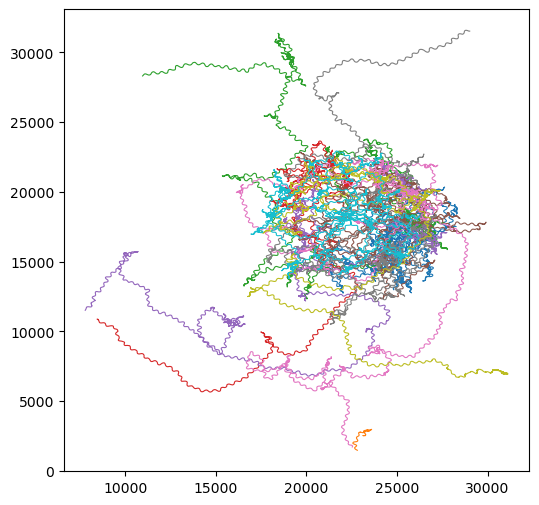

In [ ]:
plt.figure(figsize=(6, 6))



# Plot all tracks (thin lines)

for tid, g in df_vid2.groupby("track_id"):

    plt.plot(g["x_um"], g["y_um"], lw=0.8)



# Colors for labels

label_colors = {0: "green", 1: "red", 2: "black"}



# Plot labels as circles

for lid, lab in labels_vid2.items():

    color = label_colors.get(lid, "gray")

    circle = plt.Circle(

        (lab["cx_um"], lab["cy_um"]),

        lab["r_um"],

        fill=False,

        lw=2,

        edgecolor=color,

        label=f"label_{lid}"

    )

    plt.gca().add_patch(circle)



plt.gca().set_aspect("equal")

plt.xlabel("X (µm)")

plt.ylabel("Y (µm)")

plt.title("Video 2: tracks with osmotic ring and plate boundary")

plt.legend()

plt.show()
